# Mapping QTL in BXD mice using R/qtl2

[Karl Broman](https://kbroman.org)
[<img style="display:inline-block;" src="https://orcid.org/sites/default/files/images/orcid_16x16(1).gif">](https://orcid.org/0000-0002-4914-6671),
[Department of Biostatistics & Medical Informatics](https://www.biostat.wisc.edu), 
[University of Wisconsin&ndash;Madison](https://www.wisc.edu)

Our aim in this tutorial is to demonstrate how to map quantitative trait loci (QTL) in the BXD mouse recombinant inbred lines using the [R/qtl2](https://kbroman.org/qtl2) software. We will first show how to download BXD phenotypes from [GeneNetwork2](http://gn2.genenetwork.org) using its API, via the R package [R/GNapi](https://github.com/rqtl/GNapi). At the end, we will use the [R/qtl2browse](https://github.com/rqtl/qtl2browse) package to display genome scan results using the [Genetics Genome Browser](https://github.com/chfi/purescript-genome-browser).

## Acquiring phenotypes with the GeneNetwork API

We will first use the [GeneNetwork2](http://gn2.genenetwork.org) API to acquire BXD phenotypes to use for mapping. We will use the R package [R/GNapi](https://github.com/rqtl/GNapi). 

We first need to install the package, which is not available on [CRAN](https://cran.r-project.org), but is available via a private repository.

```r
install.packages("GNapi", repos="http://rqtl.org/qtl2cran")
```

We then load the package using `library()`.

In [1]:
library(GNapi)

The [R/GNapi](https://github.com/kbroman/GNapi) has a variety of functions. For an overview, see [its vignette](http://kbroman.org/GNapi/GNapi.html). Here we will just do one thing: use the function `get_pheno()` to grab BXD phenotype data. You provide a data set and a phenotype. Phenotype 10038 concerns "habituation", measured as a difference in locomotor activity between day 1 and day 3 in a 5 minute test trial. 

In [2]:
phe <- get_pheno("BXD", "10038")
head(phe)

,data_id,sample_name,sample_name_2,se,value
,<int>,<chr>,<chr>,<dbl>,<dbl>
BXD1,8967080,BXD1,BXD1,169.1,398.0
BXD11,8967080,BXD11,BXD11,77.9,355.0
BXD12,8967080,BXD12,BXD12,80.3,388.0
BXD14,8967080,BXD14,BXD14,68.3,-74.7
BXD16,8967080,BXD16,BXD16,98.7,293.0
BXD18,8967080,BXD18,BXD18,110.0,-362.0


We will use just the column "value", but we need to include the strain names so that R/qtl2 can line up these phenotypes with the genotypes.

In [3]:
pheno <- setNames(phe$value, phe$sample_name)
head(pheno)

BXD1  BXD11  BXD12  BXD14  BXD16  BXD18 
 398.0  355.0  388.0  -74.7  293.0 -362.0

## Acquire genotype data with R/qtl2

We now want to get genotype data for the BXD panel. We first need to install the [R/qtl2](https://kbroman.org/qtl2) package. As with R/GNapi, it is not available on CRAN, but rather is distributed via a private repository.

```r
install.packages("qtl2", repos="http://rqtl.org/qtl2cran")
```

We then load the package with `library()`.

In [4]:
library(qtl2)

R/qtl2 uses a special file format for QTL data ([described here](https://kbroman.org/qtl2/assets/vignettes/input_files.html)). There are a variety of sample datasets [on Github](https://github.com/rqtl/qtl2data), including genotypes for the [mouse BXD lines](https://github.com/rqtl/qtl2data/tree/master/BXD), taken from [GeneNetwork2](http://gn2.genenetwork.org). We'll load those data directly into R using the function `read_cross2()`.

In [5]:
bxd_file <- "https://raw.githubusercontent.com/rqtl/qtl2data/master/BXD/bxd.zip"
bxd <- read_cross2(bxd_file)

Warning message in recode_geno(sheet, genotypes):
“117497 genotypes treated as missing: "H"”

We get a warning message about heterozygous genotypes being omitted. A number of the newer BXD lines have considerable heterozygosity. But these lines weren't among those phenotyped in the data we downloaded above, and so we don't need to worry about it here.



In [6]:
gmap <- insert_pseudomarkers(bxd$gmap, step=0.2, stepwidth="max")

In [7]:
pmap <- interp_map(gmap, bxd$gmap, bxd$pmap)

In [8]:
pr <- calc_genoprob(bxd, gmap, error_prob=0.002, map_function="c-f")

In [9]:
k <- calc_kinship(pr, "loco")

In [10]:
out <- scan1(pr, pheno, k)

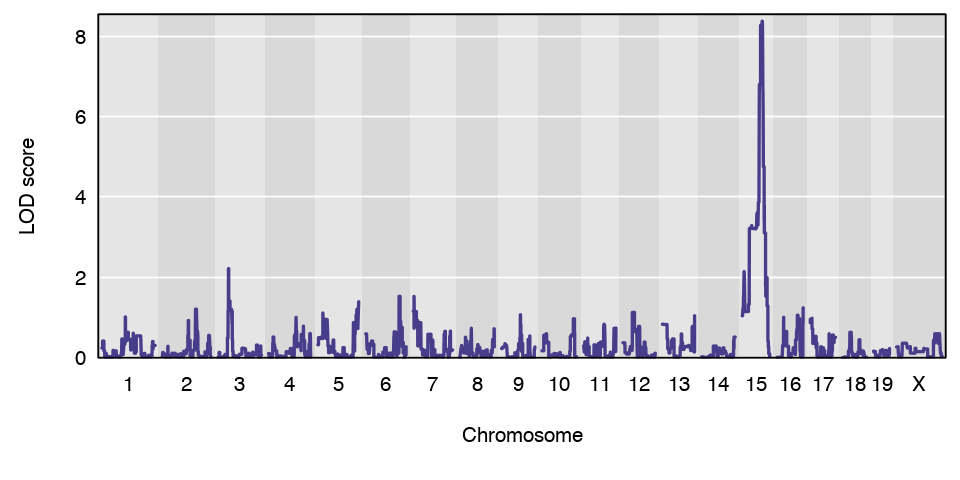

In [15]:
library(repr)
options(repr.plot.height=4, repr.plot.width=8)
par(mar=c(5.1, 4.1, 0.6, 0.6))
plot(out, pmap)

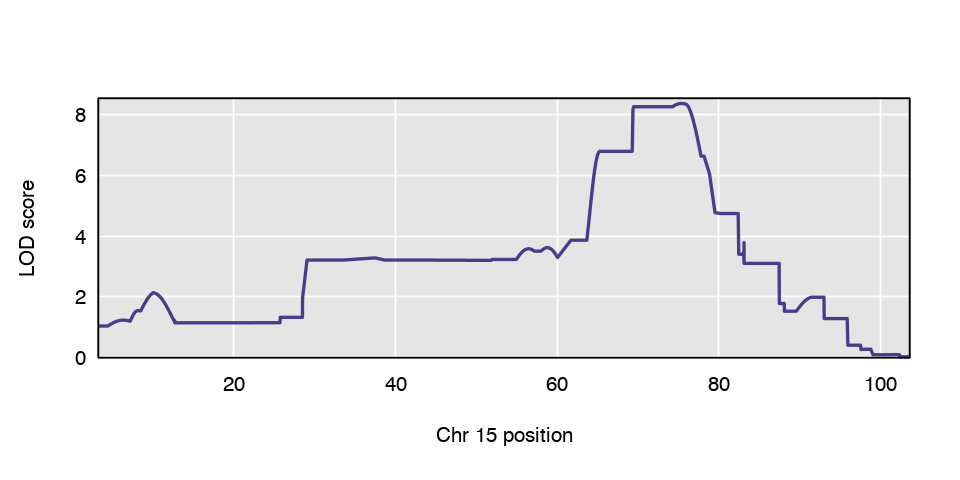

In [16]:
plot(out, pmap, chr=15)

In [17]:
mx <- max(out, pmap)
g_imp <- maxmarg(pr, pmap, chr="15", pos=mx$pos, return_char=TRUE)

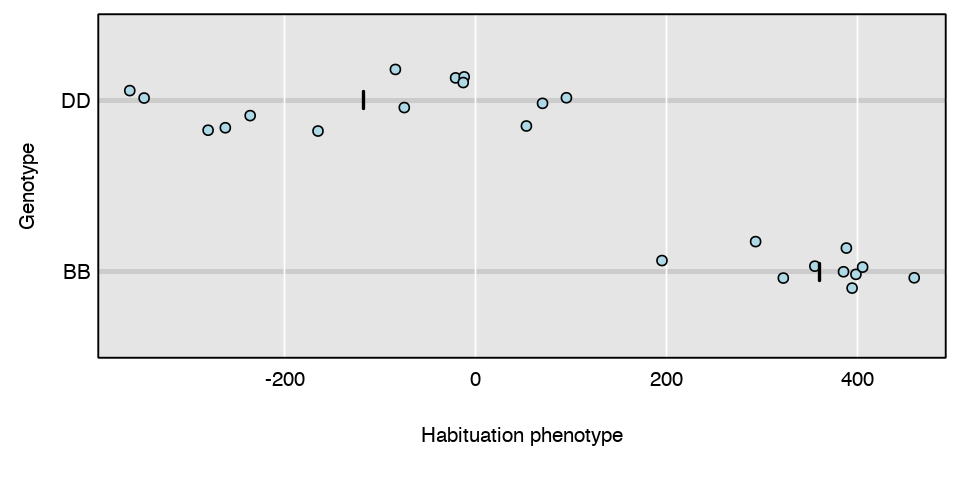

In [20]:
par(mar=c(5.1, 4.1, 0.6, 0.6))
plot_pxg(g_imp, pheno, swap_axes=TRUE, xlab="Habituation phenotype")

## Browse genome scan results with Genetics Genome Browser

The [Genetics Genome Browser](https://github.com/chfi/purescript-genome-browser) is a fast, lightweight, [purescript]-based genome browser developed for browsing GWAS or QTL analysis results. We'll use the R package [R/qtl2browse](https://github.com/rqtl/qtl2browse) to view our QTL mapping results in the GGB.

We first need to install the R/qtl2browse package, again from a private [CRAN](https://cran.r-project.org)-like repository.

```r
install.packages("qtl2browse", repos="http://rqtl.org/qtl2cran")
```

We then load the package and use its one function, `browse()`, which takes the `scan1()` output and corresponding physical map (in Mbp). This will open the Genetics Genome Browser in a separate tab in your web browser.

In [14]:
library(qtl2browse)
browse(out, pmap)